<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [3]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [ ]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [ ]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [ ]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [ ]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [ ]:
for i in range(0, Nt-1):
    T[i+1] = T[i]*(1-gamma*dt/C_s) + (dt/C_s)*(F(t[i])+theta[i]*gamma)
    theta[i+1] = theta[i]*(1-dt*gamma/C_d) +(dt*gamma/C_d)*T[i]

After you are finished, run the cell below to plot the results

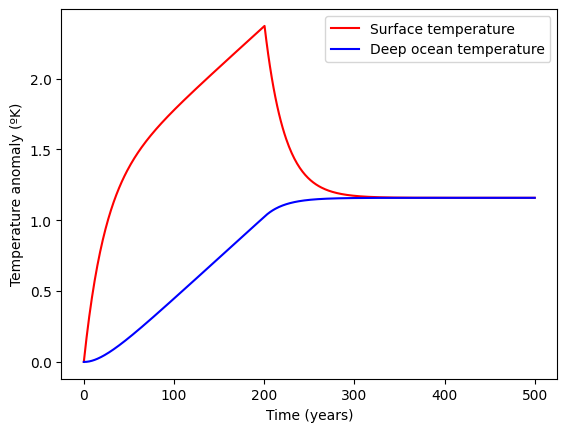

In [ ]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

In [ ]:
m=0
n=20

print((T[n]-T[m])/((n-m)*dt), (theta[n]-theta[m])/((n-m)*dt))

gamma/C_s, gamma/C_d

0.04161071490373281 0.0018757554271573201


(0.039411764705882354, 0.004294871794871795)

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

At first d_t(T) ~ F/C_s = 1/17, d_t(theta) ~ 0. As can be seen from the graph, T sharply rises to 1 over the first 20 years while theta remains near 0 at first. For 20 < t < 200, T - theta roughly equals 1 (as can be seen from the graph), so d_t(T) ~ -gamma/C_s = 0.04, d_t(theta) ~ gamma/C_d = 0.004. For 200 < t < 300, F = 0 so the behaviour of T and theta change. theta is roughly constant over this period since C_d/C_s >> 1, causing T to approach equilibrium before theta has time to change. Then solving the ODE for T, we see T approximately exponentially decays with rate -gamma/C_s

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

In [ ]:
def F(t):
    return  np.exp(-0.02*t)

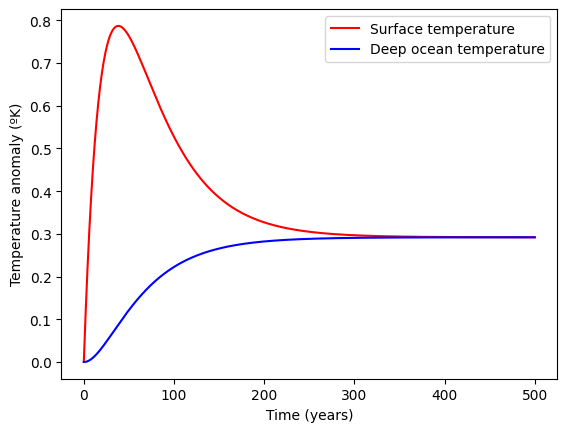

In [ ]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

In [ ]:
def F(t):
    last_year = 200
    peak_emissions = 2
    return (last_year*t-t**2)*(4*peak_emissions/last_year**2) if t < last_year else 0

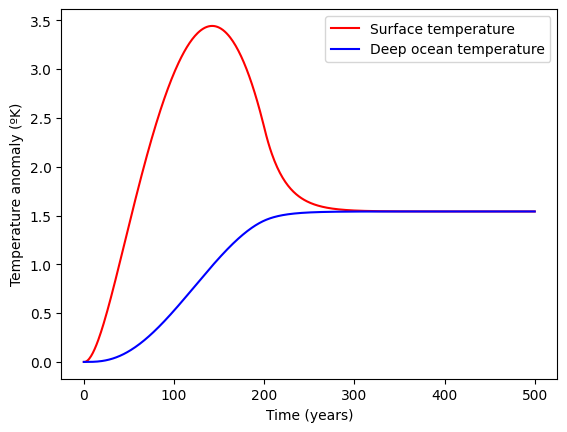

In [ ]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

In [ ]:
def F(t):
    last_year = 200
    total_emissions = last_year
    return (last_year*t-t**2)*(6*total_emissions/last_year**3) if t < last_year else 0

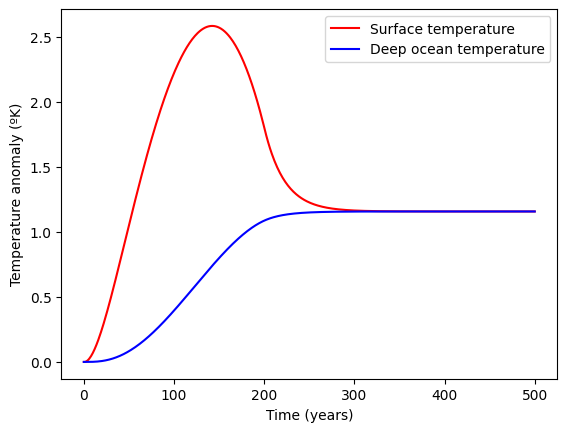

In [ ]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

I plotted three alternate scenarios, with my definitions of F above each plot.

1) This plot has emissions starting at 1W/m^2, and exponentially decaying with rate -0.02. In this scenario temperature rise is limited due to quick action, reaching equilibrium around 0.3K.

2) This plot has emissions following a parabolic curve which zeros out after reaching its second root. The paramters are last_year and peak_emissions, which at their current values of 200 and 2 cause a net temperature rise of 1.5K.

3) This scenario is nearly identical to Scenario 2, the only difference being that peak_emissions has been replaced with total_emissions. With both last_year and total_emissions being set to 200, this scenario is similar to the original scenario. The difference is the emissions now peak earlier and have a more gradual onset and offset. The total temperature rise is slightly over 1K, just like the original scenario.

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [5]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [6]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [7]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [8]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [345]:
# Defining parameters
kappa = 0.01  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [317]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson
c_Exact = Exact(x, t, kappa) #Exact unbounded, Exact() defined in 2.2

In [344]:
print(c_CN[0,:])
print(c_CN[1,:])

[0.08092522 0.03026251 0.04539863 0.03399714 0.04066308 0.03604203
 0.03969284 0.03742148 0.03963489 0.03838198 0.03979019 0.03902708
 0.03993577 0.03941981 0.0399966  0.03960668 0.03995222 0.0396249
 0.0398039  0.0395052  0.03956144 0.03927317 0.03923748 0.03895018]
[0.08092522 0.03026251 0.04539863 0.03399714 0.04066308 0.03604203
 0.03969284 0.03742148 0.03963489 0.03838198 0.03979019 0.03902708
 0.03993577 0.03941981 0.0399966  0.03960668 0.03995222 0.0396249
 0.0398039  0.0395052  0.03956144 0.03927317 0.03923748 0.03895018]


and finally, plot the results side-by-side

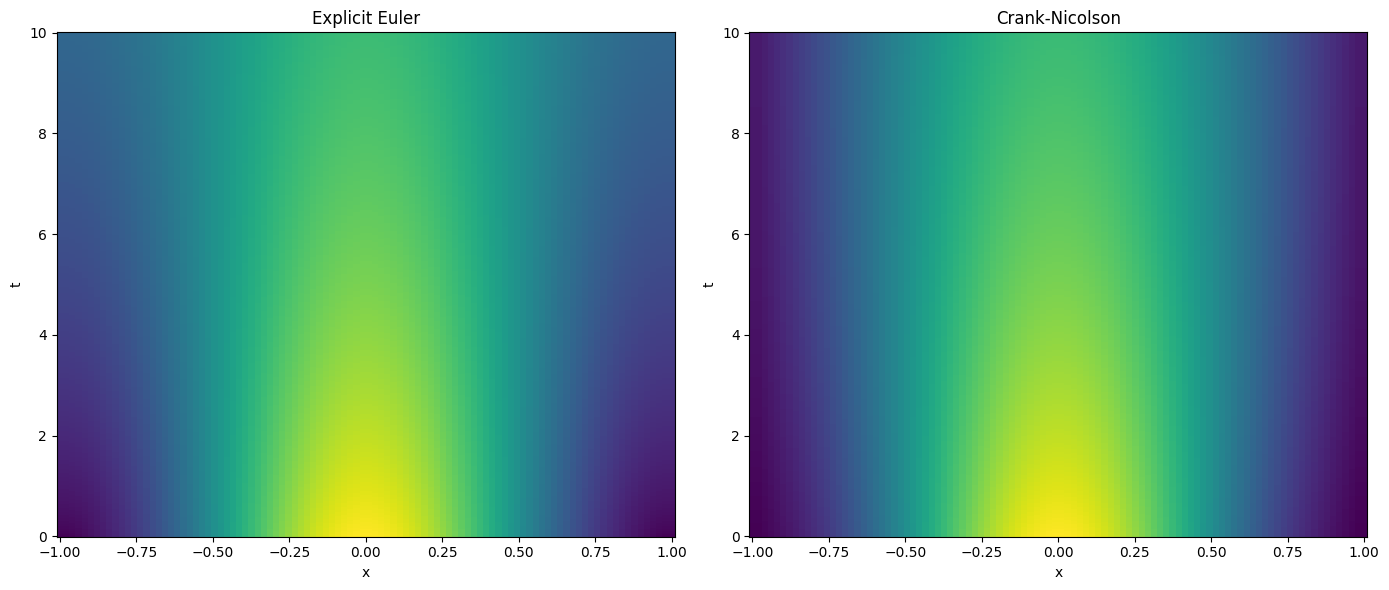

In [318]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

'''
plt.subplot(2, 2, 3)
plt.pcolormesh(x, t, c_Exact.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact')
'''

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

Increasing $\kappa$ by 1 order of magnitude has very little effect. However, as $\kappa$ increases from 0.01 to 0.031 the explicit Euler solution starts to diverge from Crank-Nicolson. At $\kappa = 0.031$ the Euler solution is effectively constant in space and time, which is highly unrealistic. At $\kappa > 0.031$ the Euler solution breaks down after a certain time. Crank-Nicolson remains valid for far longer, only starting to give unrealistic values at the boundaries between $\kappa = 10$ and $\kappa = 100$ (likely due to floating point errors encountered when computing $e^{-x^2/400t}$).

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

In [319]:
def Exact(x, t, kappa):

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    for k in range(0, Nt):
      c[:, k] = (4*np.pi*kappa*(10+k*dt))**(-0.5)*np.exp(-x**2 / (4*kappa*(10+k*dt)))

    return c

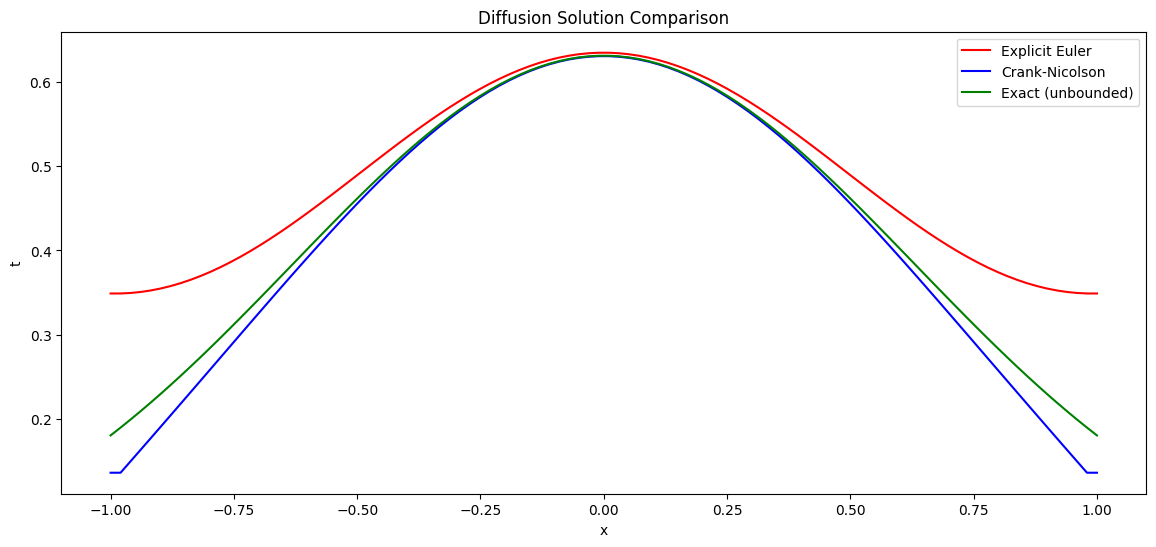

In [323]:
# Add code to plot exact and numerical solutions
plt.figure(figsize=(14, 6))

# BE CAREFUL: below arguments are given in units Nt, e.g. c_EE[:,5] is the state at t = 0.04 + t_ic
c_EE_10 = c_EE[:,-1]
c_CN_10 = c_CN[:,-1]
c_Exact_10 = c_Exact[:,-1]

plt.plot(x,c_EE_10,'r-')
plt.plot(x,c_CN_10,'b-')
plt.plot(x,c_Exact_10,'g-')
plt.legend(['Explicit Euler','Crank-Nicolson', 'Exact (unbounded)'])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Diffusion Solution Comparison')
plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

In [257]:
def EE_diff(x, delta_t, kappa):
  Nt = int(10//delta_t)
  t = np.linspace(0, 10, Nt)
  Exact_t = Exact(x,t,kappa)[:,len(t)-1]
  EE_t = EE(x,t,kappa)[:,len(t)-1]
  return np.sum(np.abs(Exact_t - EE_t))/len(x)

def CN_diff(x, delta_t, kappa):
  Nt = int(10//delta_t)
  t = np.linspace(0, 10, Nt)
  Exact_t = Exact(x,t,kappa)[:,len(t)-1]
  CN_t = CN(x,t,kappa)[:,len(t)-1]
  return np.sum(np.abs(Exact_t - CN_t))/len(x)


In [261]:
dt0 = np.linspace(0, 0.02, 300)
dt0 = dt0[1:]
ee_diff_trunc = np.array([])

for delta in dt0:
  error = EE_diff(x, delta, kappa)
  ee_diff_trunc = np.append(ee_diff_trunc, error)

In [262]:
dt1 = np.linspace(0, 0.2, 300)
dt1 = dt1[1:]
ee_diff = np.array([])

for delta in dt1:
  error = EE_diff(x, delta, kappa)
  ee_diff = np.append(ee_diff, error)

In [263]:
dt2 = np.linspace(0, 0.2, 300)
dt2 = dt2[1:]
cn_diff = np.array([])

for delta in dt2:
  error = CN_diff(x, delta, kappa)
  cn_diff = np.append(cn_diff, error)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [264]:
dt3 = np.linspace(0.02, 0.2, 300)
dt3 = dt3[1:]
cn_diff_trunc = np.array([])

for delta in dt3:
  error = CN_diff(x, delta, kappa)
  cn_diff_trunc = np.append(cn_diff_trunc, error)

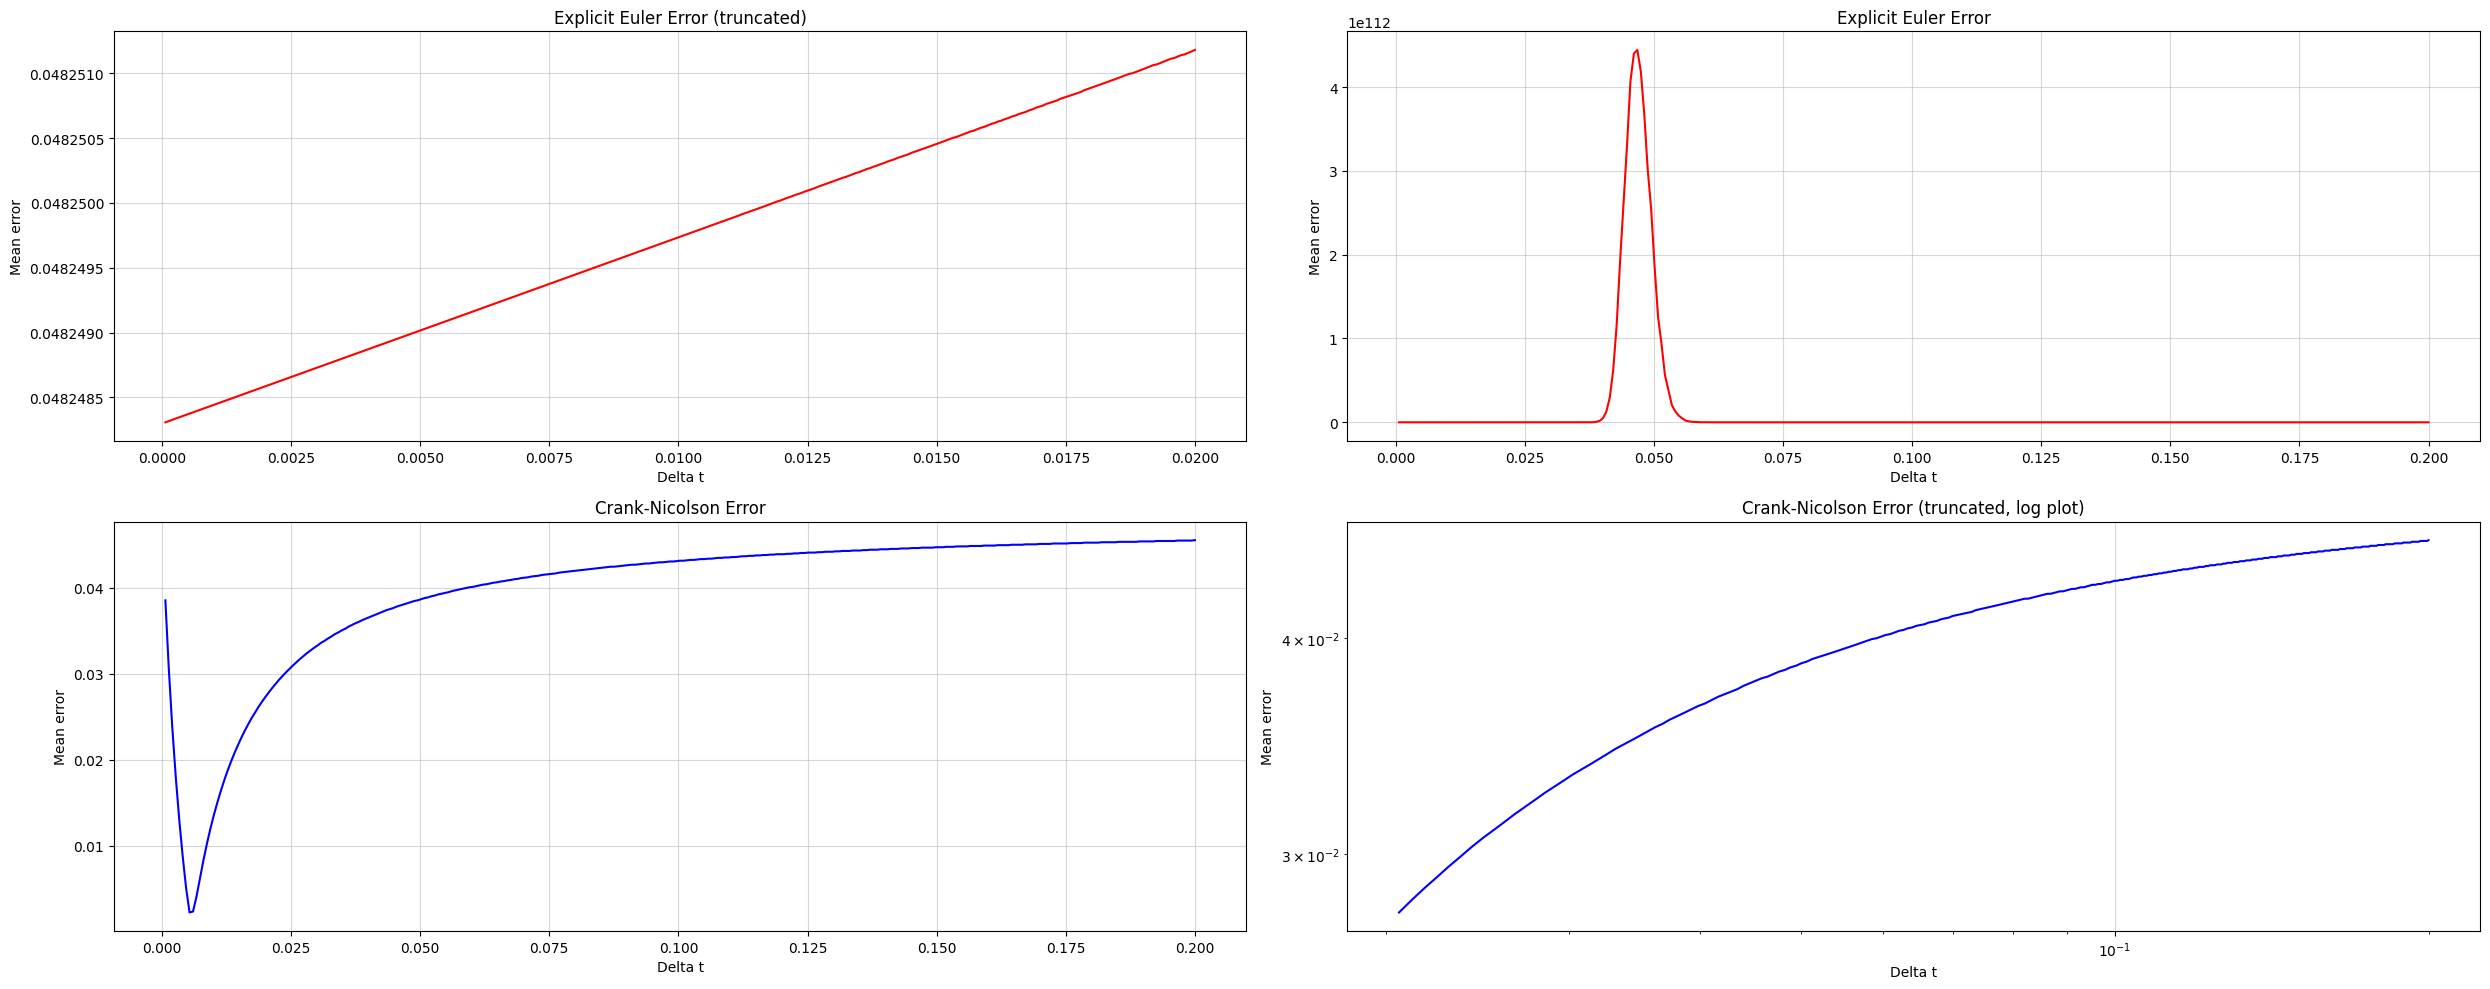

In [338]:
# ee_diff_adj = abs(ee_diff - ee_diff[0])

plt.figure(figsize=(25, 10))

plt.subplot(2, 2, 1)
plt.plot(dt0, ee_diff_trunc,'r-')
plt.grid(True, alpha = 0.5)
plt.xlabel('Delta t')
plt.ylabel('Mean error')
plt.title('Explicit Euler Error (truncated)')


plt.subplot(2, 2, 2)
plt.plot(dt1, ee_diff,'r-')
plt.grid(True, alpha = 0.5)
plt.xlabel('Delta t')
plt.ylabel('Mean error')
plt.title('Explicit Euler Error')

plt.subplot(2, 2, 3)
plt.plot(dt2, cn_diff,'b-')
plt.grid(True, alpha = 0.5)
plt.xlabel('Delta t')
plt.ylabel('Mean error')
plt.title('Crank-Nicolson Error')

plt.subplot(2, 2, 4)
plt.loglog(dt3, cn_diff_trunc,'b-')
plt.grid(True, alpha = 0.5)
plt.xlabel('Delta t')
plt.ylabel('Mean error')
plt.title('Crank-Nicolson Error (truncated, log plot)')

plt.tight_layout()
plt.show()


The utility of these graphs for inferring order of accuracy is limited, since the "exact" solution here is really an exact solution to the unbounded diffusion equation. The Explicit Euler global error is clearly an affine function of dt for $\Delta t < 0.02$, indicating that the global error compared to the bounded exact solution is probably linear. Explicit Euler is also clearly unstable for sufficiently large $\Delta t$. The sharp decrease the Crank Nicolson graph near 0 likely occurs because the "exact" solution used here slightly differs from the bounded exact solution. The rest of the graph doesn't seem to follow a strict power law based on the log plot.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

I'll choose an error of 0.4825, since the Explicit Euler error is around this value for small dt. Using the above graphs and experimenting with different values it can be seen that Explicit Euler has an error of 0.4825 at $\Delta t = 0.0119$. Crank Nicolson has a smaller error and runs faster at $\Delta t = 0.4$.

In [334]:
print(f"Explicit Euler has an error of {EE_diff(x, 0.0118, kappa)} at dt = 0.0118")
print(f"Explicit Euler has an error of {EE_diff(x, 0.0119, kappa)} at dt = 0.0119")
print(f"Crank-Nicolson has an error of {CN_diff(x, 0.4, kappa)} at dt = 0.4")

t =  np.linspace(0, 10, int(10//0.0118))

start_time = time.time()
EE(x, t, kappa)
end_time = time.time()  # Print the elapsed time
print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

t =  np.linspace(0, 10, int(10//0.4))

start_time = time.time()
CN(x, t, kappa)
end_time = time.time()  # Print the elapsed time
print(f"Crank Nicolson method took {end_time - start_time:.2f} seconds")


Explicit Euler has an error of 0.048249994097433115 at dt = 0.0118
Explicit Euler has an error of 0.048250008248896775 at dt = 0.0119
Crank-Nicolson has an error of 0.04679301260906552 at dt = 0.4
Explicit Euler method took 0.04 seconds
Crank Nicolson method took 0.03 seconds


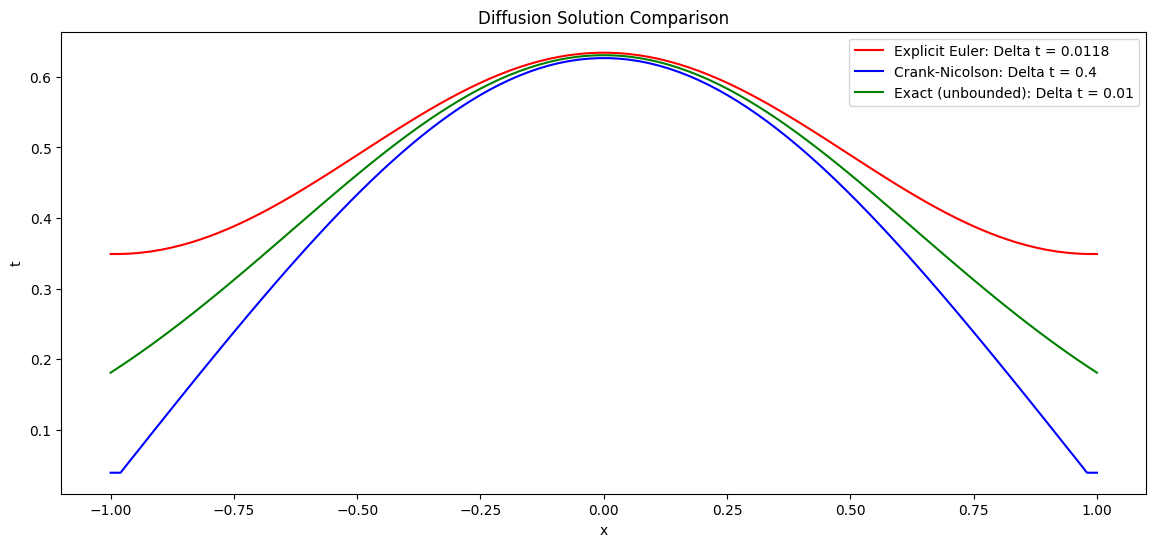

In [339]:
# Run the simulations
c_EE = EE(x, np.linspace(0, 10, int(10//0.0118)), kappa) # explicit Euler
c_CN = CN(x, np.linspace(0, 10, int(10//0.4)), kappa) # Crank-Nicolson
c_Exact = Exact(x, np.linspace(0, 10, int(10//0.01)), kappa) #Exact unbounded

# Add code to plot exact and numerical solutions
plt.figure(figsize=(14, 6))

# BE CAREFUL: below arguments are given in units Nt, e.g. c_EE[:,5] is the state at t = 0.04 + t_ic
c_EE_10 = c_EE[:,-1]
c_CN_10 = c_CN[:,-1]
c_Exact_10 = c_Exact[:,-1]

plt.plot(x,c_EE_10,'r-')
plt.plot(x,c_CN_10,'b-')
plt.plot(x,c_Exact_10,'g-')
plt.legend(['Explicit Euler: Delta t = 0.0118','Crank-Nicolson: Delta t = 0.4', 'Exact (unbounded): Delta t = 0.01'])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Diffusion Solution Comparison')
plt.show()

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

Dirichlet boundary conditions: suppose the boundary sonditions were $c(0) = a, \ c(L)= b$. I would handle them by setting c[0, k] = a, c[-1, k] = b after each forward integration.


Neumann boundary conditions: suppose the boundary sonditions were $\partial_xc(0) = a, \ \partial_xc(L)= b$. I would handle them by setting dx = x[1] - x[0], c[0, k] = c[1,k] - a\*dx, c[-1, k] =  c[-2,k] + b\*dx after each forward integration.
